In [14]:
import numpy as np
import dit
from mutual_info import compute_mi as mi
from mutual_info import compute_cmi as cmi
from matplotlib import pyplot as plt
from scipy.linalg import cholesky
from tqdm import tqdm
%config InlineBackend.figure_format='retina'

In [83]:
def PID_continuous(s1,s2,t):
    I1    = mi(s1,t,n_neighbors=10)
    I2    = mi(s2,t,n_neighbors=10)
    I12   = cmi(t,s1,s2,n_neighbors=10) + mi(t,s2,n_neighbors=10) 
    r_mmi = np.min([I1,I2])
    u1    = I1-r_mmi
    u2    = I2-r_mmi
    s     = I12-u1-u2-r_mmi
    return (u1,u2,r_mmi,s)

def symbol_joint_distribution(*random_variates):
    def joint_symbols_to_string(bits:np.ndarray[np.int32])->str:
        return np.array2string(bits,separator='')[1:-1]
    joint_symbols,frequencies = np.unique(list(zip(*random_variates)), axis=0, return_counts=True)
    symbol_strings            = list(map(joint_symbols_to_string,joint_symbols))
    distribution              = dit.Distribution(symbol_strings, frequencies/sum(frequencies))
    return distribution

def read_pid_table(pid_table: str): 
    pid_dict = {}
    pid_rows = pid_table.split('\n')[3:-1]
    for row in pid_rows:
        contents = row.split('|')
        pid_dict[contents[1].strip()] = float(contents[3])
    return pid_dict

In [74]:
a = -0.1
b = 0.6
c = 0.5

cov = np.array([[1,a,c],
                [a,1,b],
                [c,b,1]])
lowc   = cholesky(cov, lower=True)

In [78]:
#Gaussian random variates
x,y,z = np.random.multivariate_normal(np.zeros(3),cov,size=5000).T

In [53]:
# #Laplacian random variates
# xyz    = np.random.laplace(size=(3,7500))
# x,y,z  = np.dot(lowc, xyz)

In [84]:
s1 = y
s2 = z
t  = x

#Mutual information terms
I1  = mi(s1,t,n_neighbors=10) # x vs y
I2  = mi(s2,t,n_neighbors=10) # x vs z
I12 = cmi(t,s1,s2,n_neighbors=10) + mi(t,s2,n_neighbors=10) 
#continuous partial information decomposition
r_mmi     = np.min([I1,I2])
u1        = I1-r_mmi
u2        = I2-r_mmi
s         = I12-u1-u2-r_mmi

In [85]:
print('I(s1,t):   ',round(I1,5),round(0.5 * np.log(1/(1-a**2)),5))
print('I(s2,t):   ',round(I2,5),round(0.5 * np.log(1/(1-c**2)),5))
print('redundancy:',round(r_mmi,5),round(mi(x,y,n_neighbors=10),5))
print('unique1:   ',u1,'   ',0.0)
print('unique2:   ',u2,round(0.5 * np.log((1-a**2)/(1-c**2)),5))
print('synergy:   ',s,0.5 * np.log(((1-b**2)*(1-c**2))/(1-(a**2+b**2+c**2)+2*a*b*c)))

I(s1,t):    0 0.00503
I(s2,t):    0.15192 0.14384
redundancy: 0.0 0
unique1:    0.0     0.0
unique2:    0.15191989516137738 0.13882
synergy:    0.19843463684041662 0.2027325540540822


In [86]:
PID_continuous(s1,s2,t)

(0.0, 0.15191989516137738, 0.0, 0.19843463684041662)

In [66]:
nsymbols      = range(2,10) 
synergies     = []
synergies_rnd = []
for n in tqdm(nsymbols):
    pctls = np.linspace(0,100,n)[:-1]
    
    x_boundaries = [np.percentile(x,q) for q in pctls]
    x_bin        = np.digitize(x,x_boundaries)

    y_boundaries = [np.percentile(y,q) for q in pctls]
    y_bin        = np.digitize(y,y_boundaries)

    z_boundaries = [np.percentile(z,q) for q in pctls]
    z_bin        = np.digitize(z,z_boundaries)
    
    distro    = symbol_joint_distribution(x_bin,y_bin,z_bin)
    pid_atoms = read_pid_table(dit.pid.PID_WB(distro).to_string())
    synergies.append(pid_atoms['{0:1}'])
    
    x_bin_rnd = np.random.permutation(x_bin)
    y_bin_rnd = np.random.permutation(y_bin)
    z_bin_rnd = np.random.permutation(z_bin)
    
    distro_rnd    = symbol_joint_distribution(x_bin_rnd,y_bin_rnd,z_bin_rnd)
    pid_atoms_rnd = read_pid_table(dit.pid.PID_WB(distro_rnd).to_string())
    synergies_rnd.append(pid_atoms_rnd['{0:1}'])

 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:13<00:04,  2.26s/it]


KeyboardInterrupt: 

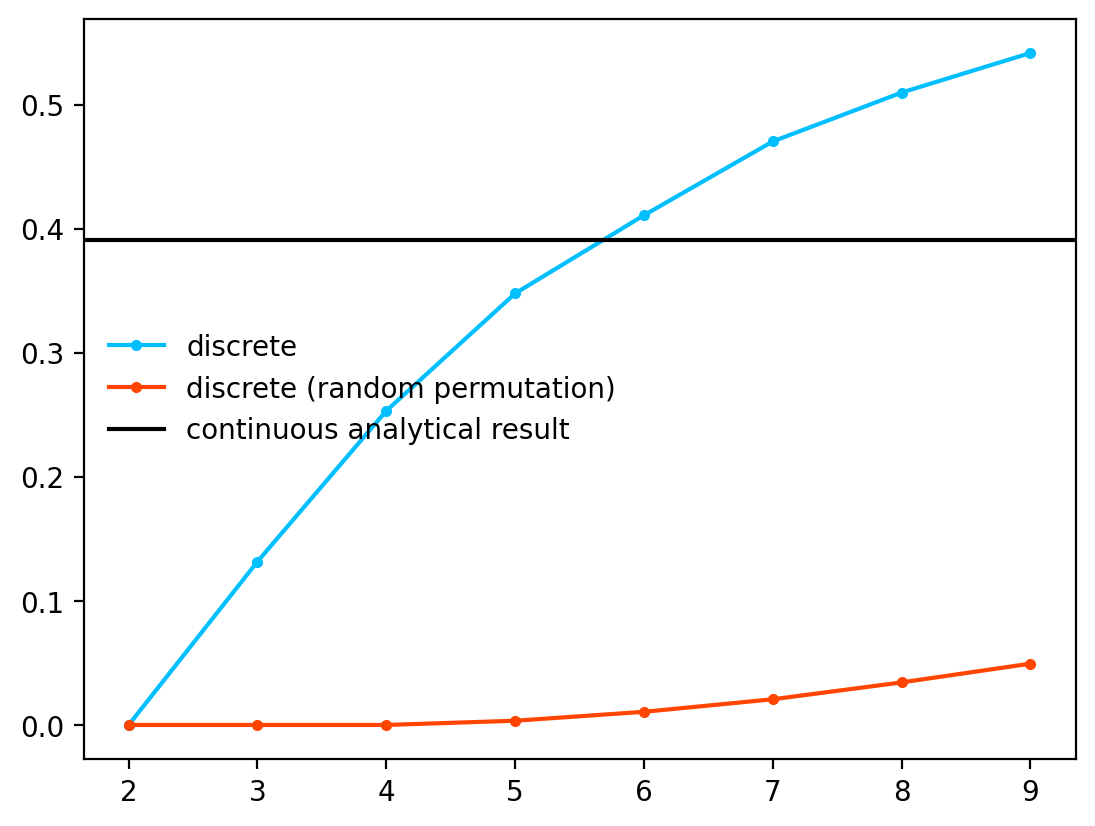

In [9]:
cont_val = 0.5 * np.log(((1-b**2)*(1-c**2))/(1-(a**2+b**2+c**2)+2*a*b*c))
plt.plot(nsymbols,synergies,marker='.',c='deepskyblue',label='discrete')
plt.plot(nsymbols,synergies_rnd,marker='.',c='orangered',label='discrete (random permutation)')
plt.axhline(cont_val,c='black',label='continuous analytical result')
plt.legend(frameon=False,loc=6)

# Observations

 - Discretization also capture synergies in the situations that seem counterintuitive shown in the Barret's paper
 
 
  - Synergy grows in magnitude as we use more symbols in the discretization, something that also can happen with mutual information. This is not surprising.